In [1]:
# Add scripts directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'scripts'))
import pytz

# Import geometry functions
from geometry import (
    download_country_shapes,
    download_nuts3_shapes,
    join_shapes,
    point_in_shape,
    mask_shape,
    buffer_shape,
    get_shape_area,
    get_european_union_shape,
    load_shapes_efficiently,
    to_rect,
    to_point
)

# For visualization
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import curve_fit

print("✓ Setup complete")

# default figures path

figures_path = Path("/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/figures")

def find_repo_root(max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / 'README.md').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd().resolve()

repo_root = find_repo_root()

print(f"Repository root: {repo_root}")


✓ Setup complete
Repository root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


In [2]:
import json

JOIN = False

# Define cache dir
cache_dir = Path.cwd().parent / 'data' / 'cache' / 'geometry'

# Candidate paths (in preferred order)

all_countries_candidates = [
    cache_dir / 'all_countries.geojson',
    cache_dir / 'all_countries.parquet',
]
if JOIN:
    voronoi_candidates = [
        cache_dir / 'voronoi_eu27_join_P.geojson',
        cache_dir / 'voronoi_eu27_join_P.parquet',
        cache_dir / 'voronoi_eu27_join.geojson',
        cache_dir / 'voronoi_eu27_join.parquet',
    ]
    csv_candidates = [
        cache_dir / 'voronoi_eu27_join_population.csv',
    ]
else:
    voronoi_candidates = [
        cache_dir / 'voronoi_eu27_P.geojson',
        cache_dir / 'voronoi_eu27_P.parquet',
        cache_dir / 'voronoi_eu27.geojson',
        cache_dir / 'voronoi_eu27.parquet',
    ]
    csv_candidates = [
        cache_dir / 'voronoi_eu27_population.csv',
    ]

def first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

all_countries_path = first_existing(all_countries_candidates)
voronoi_eu27_path = first_existing(voronoi_candidates)

if all_countries_path and voronoi_eu27_path:
    # Load geometries
    all_countries_geojson = load_shapes_efficiently(all_countries_path)
    try: 
        all_countries_gdf = gpd.GeoDataFrame.from_features(all_countries_geojson['features'])
    except Exception as e:
        print(f"⚠ Failed to load all_countries GeoDataFrame: {e}")
        all_countries_gdf = all_countries_geojson
    
    voronoi_geojson = load_shapes_efficiently(voronoi_eu27_path)
    try:
        voronoi_gdf = gpd.GeoDataFrame.from_features(voronoi_geojson['features'])
    except Exception as e:
        print(f"⚠ Failed to load voronoi_eu27 GeoDataFrame: {e}")
        voronoi_gdf = voronoi_geojson
    
    # Load buses
    buses_path = Path.cwd().parent / 'data' / 'raw' / 'OSM Prebuilt Electricity Network' / 'buses.csv'
    if buses_path.exists():
        buses_data = pd.read_csv(buses_path)
        print(f"✓ Loaded {len(all_countries_gdf)} countries")
        print(f"✓ Loaded {len(voronoi_gdf)} Voronoi cells")
        print(f"✓ Loaded {len(buses_data)} buses")
    else:
        buses_data = None
        print(f"⚠ Buses file not found at {buses_path}")
else:
    print("⚠ Cache files not found")
    print("  Tried all_countries candidates:")
    for p in all_countries_candidates:
        print(f"    - {p} (exists={p.exists()})")
    print("  Tried voronoi candidates:")
    for p in voronoi_candidates:
        print(f"    - {p} (exists={p.exists()})")
    buses_data = None


⚠ Failed to load all_countries GeoDataFrame: 'features'
⚠ Failed to load voronoi_eu27 GeoDataFrame: 'features'
✓ Loaded 35 countries
✓ Loaded 6258 Voronoi cells
✓ Loaded 6737 buses


In [3]:
# Load csv candidates
pop_csv = first_existing(csv_candidates)

# To pandasa DataFrame
if pop_csv:
    population_data = pd.read_csv(pop_csv, index_col=0)
    print(f"\n✓ Loaded population data from {pop_csv} with {len(population_data)} entries.")
    print("\nSample population data:")
    display(population_data.head())


✓ Loaded population data from /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/cache/geometry/voronoi_eu27_population.csv with 6258 entries.

Sample population data:


,population,EU_population_share
bus_id,,
AT1-220,9941.0,0.000022
AT10-220,43914.0,0.000097
AT11-220,49063.0,0.000109
AT12-380,58700.0,0.000130
AT13-380,84807.0,0.000188


In [4]:
load_data_path = repo_root / "data" / "raw" / "energy_charts" / "combined_load_data.csv"
load_data = pd.read_csv(load_data_path, index_col=0, parse_dates=True)
unique_countries = load_data['Country'].unique()
country_load_data = load_data[load_data['Country'] == 'IE']
country_load_data = country_load_data.drop('Country', axis=1)
country_load_data




,Load
Timestamp,
2015-01-01 01:00:00+01:00,2903.3
2015-01-01 02:00:00+01:00,2726.2
2015-01-01 03:00:00+01:00,2487.6
2015-01-01 04:00:00+01:00,2311.8
2015-01-01 05:00:00+01:00,2166.5
...,...
2024-12-29 18:00:00+01:00,4300.4
2024-12-29 19:00:00+01:00,4356.5
2024-12-29 20:00:00+01:00,4231.7


<Axes: title={'center': 'IE Electricity Load Data'}, xlabel='Timestamp'>

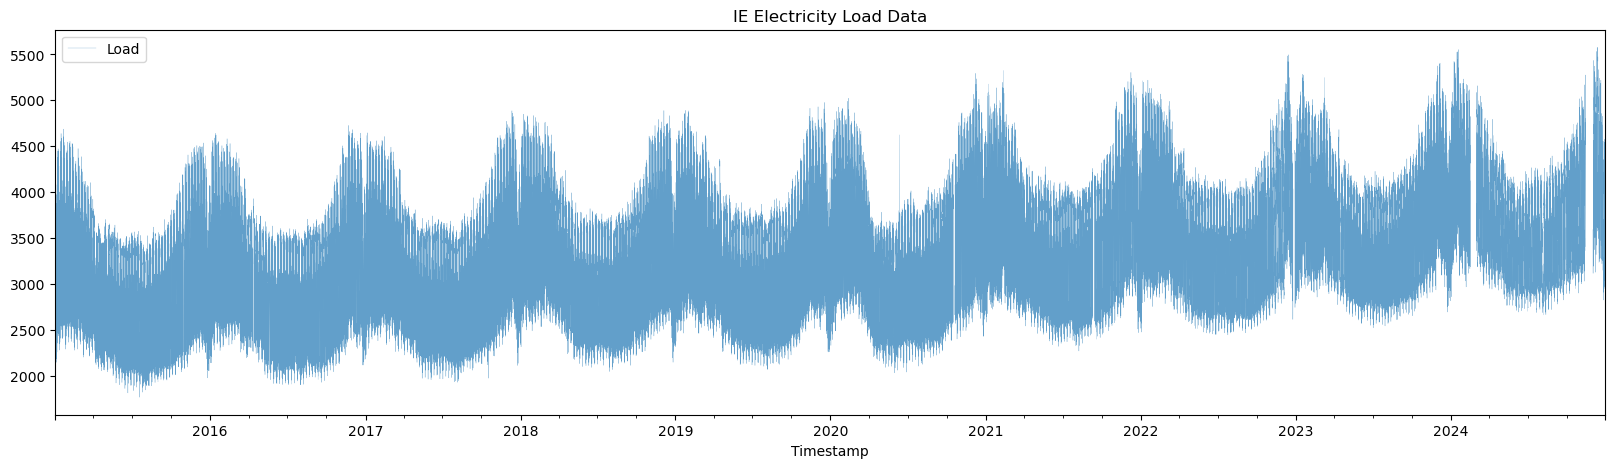

In [5]:
country_load_data.plot(figsize=(20,5), title='IE Electricity Load Data', linewidth=0.2, alpha=0.7)

In [6]:
series = pd.Series(country_load_data['Load'].tolist(), index=country_load_data.index, )
series.name = 'Load'
series

Timestamp
2015-01-01 01:00:00+01:00    2903.3
2015-01-01 02:00:00+01:00    2726.2
2015-01-01 03:00:00+01:00    2487.6
2015-01-01 04:00:00+01:00    2311.8
2015-01-01 05:00:00+01:00    2166.5
                              ...  
2024-12-29 18:00:00+01:00    4300.4
2024-12-29 19:00:00+01:00    4356.5
2024-12-29 20:00:00+01:00    4231.7
2024-12-29 21:00:00+01:00    4099.9
2024-12-29 22:00:00+01:00    3962.2
Name: Load, Length: 87622, dtype: float64

In [7]:
load_data.index = load_data.index.tz_convert("UTC")
load_data

,Country,Load
Timestamp,,
2015-01-01 00:00:00+00:00,AT,6017.2
2015-01-01 01:00:00+00:00,AT,5750.8
2015-01-01 02:00:00+00:00,AT,5407.2
2015-01-01 03:00:00+00:00,AT,5284.8
2015-01-01 04:00:00+00:00,AT,5280.4
...,...,...
2024-12-31 18:00:00+00:00,NO,20104.2
2024-12-31 19:00:00+00:00,NO,19122.6
2024-12-31 20:00:00+00:00,NO,18756.9


In [8]:
v_multi = np.vectorize(lambda x,y: y*x)

In [9]:
# Function that finds missing values if there are more than n_missing in a row. It should print out the time ranges where missing values are found (from first not missing to last missing)
def find_missing_ranges(df, n_missing=6):
    missing_ranges = []
    in_missing = False
    start_missing = None
    missing_count = 0

    for idx, row in df.iterrows():
        if pd.isna(row['Load']):
            if not in_missing:
                in_missing = True
                start_missing = idx
            missing_count += 1
        else:
            if in_missing:
                if missing_count >= n_missing:
                    missing_ranges.append((start_missing, idx))
                in_missing = False
                missing_count = 0

    # Check if we ended while still in a missing range
    if in_missing and missing_count >= n_missing:
        missing_ranges.append((start_missing, df.index[-1]))

    return missing_ranges



In [12]:
load_data[(load_data['Country'] == 'IE')]

,Country,Load
Timestamp,,
2015-01-01 00:00:00+00:00,IE,2903.3
2015-01-01 01:00:00+00:00,IE,2726.2
2015-01-01 02:00:00+00:00,IE,2487.6
2015-01-01 03:00:00+00:00,IE,2311.8
2015-01-01 04:00:00+00:00,IE,2166.5
...,...,...
2024-12-29 17:00:00+00:00,IE,4300.4
2024-12-29 18:00:00+00:00,IE,4356.5
2024-12-29 19:00:00+00:00,IE,4231.7


In [ ]:
time_2015_to_2024 = pd.date_range(start='2015-01-01', end='2024-12-31 23:00', freq='h', tz='UTC').tz_convert(pytz.FixedOffset(60))

# Create DataFrame with time index and 3 columns, Timestamp, Country, Load

df = pd.DataFrame()

for country in unique_countries:
    newdf = pd.DataFrame()
    newdf.index = time_2015_to_2024
    newdf.index.name = 'Timestamp'
    newdf['Country'] = country
    
    
    country_load_data = load_data[load_data['Country'] == country]
    country_load_data = country_load_data.drop('Country', axis=1)
    country_load_data['Missing'] = country_load_data['Load'].isna()
    newdf = newdf.merge(country_load_data, left_index=True, right_index=True, how='left')
    if country == 'UK':
        # Set to 0 after 2022-01-01
        #newdf.loc[(newdf.index >= '2022-01-01 01:00:00+01:00'), 'Load'] = np.nan
        newdf.loc[(newdf.index >= '2021-06-14 09:00:00+01:00') & (newdf.index <= '2022-06-14 08:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-06-14 08:00:00+01:00'), 'Load'].to_list(),0.975)
        newdf.loc[(newdf.index >= '2022-06-14 09:00:00+01:00') & (newdf.index <= '2023-06-14 08:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-06-14 08:00:00+01:00'), 'Load'].to_list(),0.95)
        #newdf.loc[(newdf.index >= '2023-06-14 09:00:00+01:00') & (newdf.index <= '2024-06-14 08:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-06-14 10:00:00+01:00'), 'Load'].to_list(),0.85)
        newdf.loc[(newdf.index >= '2023-06-14 09:00:00+01:00') & (newdf.index <= '2024-02-28 23:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-02-28 23:00:00+01:00'), 'Load'].to_list(),0.91)
        newdf.loc[(newdf.index >= '2024-02-29 00:00:00+01:00') & (newdf.index <= '2024-02-29 23:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2024-02-28 00:00:00+01:00') & (newdf.index <= '2024-02-28 23:00:00+01:00'), 'Load'].to_list(),1.0)
        newdf.loc[(newdf.index >= '2024-03-01 00:00:00+01:00') & (newdf.index <= '2024-06-14 08:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2021-03-01 00:00:00+01:00') & (newdf.index <= '2021-06-14 08:00:00+01:00'), 'Load'].to_list(),0.91)
        newdf.loc[(newdf.index >= '2024-06-14 09:00:00+01:00') & (newdf.index <= '2025-01-01 00:00:00+01:00'), 'Load'] = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-01-01 00:00:00+01:00'), 'Load'].to_list(),0.91)
        newdf['Load'] = newdf['Load'].interpolate(method='time')
        df = pd.concat([df, newdf])
        continue
    
    if newdf['Load'].isna().all():
        df = pd.concat([df, newdf])
        continue
    
    if country == 'IE':
        miss = find_missing_ranges(newdf, 7)
        for start, end in miss:
            leng = (end - start).total_seconds() / 3600
            print(f"Missing range for IE from {start} to {end}, length: {leng} hours")
            previous_day_start = start - pd.DateOffset(days=1)
            previous_day_end = end - pd.DateOffset(days=1)
            # If the time interval from previous day has at most 1 missing value, use it to fill the current missing values
            #print(f"Checking previous day from {previous_day_start} to {previous_day_end}")
            if newdf.loc[previous_day_start:previous_day_end, 'Load'].isna().sum() <= 1:
                if len(newdf.loc[start:end, 'Load']) != len(newdf.loc[previous_day_start:previous_day_end, 'Load']):
                    print(f"Length of current missing data: {len(newdf.loc[start:end, 'Load'])} hours")
                    print(f"Length of previous day data: {len(newdf.loc[previous_day_start:previous_day_end, 'Load'])} hours")
                newdf.loc[start:end, 'Load'] = newdf.loc[previous_day_start:previous_day_end, 'Load'].values
                print(f"Filled missing range for IE from {start} to {end} using previous day's data")
                continue
            # We check for the next day as well
            next_day_start = start + pd.DateOffset(days=1)
            next_day_end = end + pd.DateOffset(days=1)
            #print(f"Checking next day from {next_day_start} to {next_day_end}")
            if newdf.loc[next_day_start:next_day_end, 'Load'].isna().sum() <= 1:
                if len(newdf.loc[start:end, 'Load']) != len(newdf.loc[next_day_start:next_day_end, 'Load']):
                    print(f"Length of current missing data: {len(newdf.loc[start:end, 'Load'])} hours")
                    print(f"Length of next day data: {len(newdf.loc[next_day_start:next_day_end, 'Load'])} hours")
                newdf.loc[start:end, 'Load'] = newdf.loc[next_day_start:next_day_end, 'Load'].values
                print(f"Filled missing range for IE from {start} to {end} using next day's data")
                continue
            # Otherwise, use data from 1 years ago if available
            previous_year_start = start - pd.DateOffset(years=1)
            previous_year_end = end - pd.DateOffset(years=1)
            # If the time interval from previous year has at most 1 missing value, use it to fill the current missing values
            prev_year = newdf.loc[previous_year_start:previous_year_end]
            if find_missing_ranges(prev_year,8) == []:
                a= len(newdf.loc[start:end, 'Load'])
                b= len(newdf.loc[previous_year_start:previous_year_end, 'Load'])
                if a != b:
                    # That means we are tryinh to fill a leap year day with non-leap year data or vice versa
                    if a > b:
                        # Current missing data is longer, we are filling Feb 29
                        # We fill everything for Feb 28 and take Feb 28 value for Feb 29 or till its missing 
                        newdf.loc[start:end, 'Load'] = np.concatenate([
                            newdf.loc[previous_year_start:previous_year_end, 'Load'].values,
                            np.full((a - b,), newdf.loc[previous_year_end, 'Load'])
                        ])
                    else:
                        # Previous year data is longer, we are filling Feb 28 with Feb 29 data
                        newdf.loc[start:end, 'Load'] = newdf.loc[previous_year_start:previous_year_end - pd.DateOffset(hours=(b - a)), 'Load'].values
                else:
                    newdf.loc[start:end, 'Load'] = newdf.loc[previous_year_start:previous_year_end, 'Load'].values
                print(f"Filled missing range for IE from {start} to {end} using previous year's data")
                continue
            # If not possible, give a warning
            print(f"⚠ Could not fill missing range for IE from {start} to {end}")
            
        df = pd.concat([df, newdf])
        
        continue
        
    # Fill missing values with linear interpolation
    newdf['Load'] = newdf['Load'].interpolate(method='time')
    df = pd.concat([df, newdf])

Missing range for IE from 2015-10-29 16:00:00+00:00 to 2015-10-30 11:00:00+00:00, length: 19.0 hours
Filled missing range for IE from 2015-10-29 16:00:00+00:00 to 2015-10-30 11:00:00+00:00 using previous day's data
Missing range for IE from 2015-11-04 22:00:00+00:00 to 2015-11-05 06:00:00+00:00, length: 8.0 hours
Filled missing range for IE from 2015-11-04 22:00:00+00:00 to 2015-11-05 06:00:00+00:00 using previous day's data
Missing range for IE from 2016-04-11 21:00:00+00:00 to 2016-04-13 14:00:00+00:00, length: 41.0 hours
Filled missing range for IE from 2016-04-11 21:00:00+00:00 to 2016-04-13 14:00:00+00:00 using previous year's data
Missing range for IE from 2016-05-19 14:00:00+00:00 to 2016-05-20 11:00:00+00:00, length: 21.0 hours
Filled missing range for IE from 2016-05-19 14:00:00+00:00 to 2016-05-20 11:00:00+00:00 using previous day's data
Missing range for IE from 2016-11-17 09:00:00+00:00 to 2016-11-17 22:00:00+00:00, length: 13.0 hours
Filled missing range for IE from 2016-1

ValueError: Must have equal len keys and value when setting with an iterable

In [22]:
find_missing_ranges(df[df['Country'] == 'IE'], 8)

[(Timestamp('2024-02-16 09:00:00+0000', tz='UTC'),
  Timestamp('2024-03-01 00:00:00+0000', tz='UTC'))]

In [239]:
import builtins
print(builtins.len(newdf.loc[(newdf.index >= '2023-06-14 09:00:00+01:00') & (newdf.index <= '2024-06-14 08:00:00+01:00'), 'Load']))
res = v_multi(newdf.loc[(newdf.index >= '2020-06-14 09:00:00+01:00') & (newdf.index <= '2021-06-14 10:00:00+01:00'), 'Load'].to_list(),0.85)
print(builtins.len(res))

8784
8762


In [118]:
time_2015_to_2024

DatetimeIndex(['2015-01-01 01:00:00+01:00', '2015-01-01 02:00:00+01:00',
               '2015-01-01 03:00:00+01:00', '2015-01-01 04:00:00+01:00',
               '2015-01-01 05:00:00+01:00', '2015-01-01 06:00:00+01:00',
               '2015-01-01 07:00:00+01:00', '2015-01-01 08:00:00+01:00',
               '2015-01-01 09:00:00+01:00', '2015-01-01 10:00:00+01:00',
               ...
               '2024-12-31 15:00:00+01:00', '2024-12-31 16:00:00+01:00',
               '2024-12-31 17:00:00+01:00', '2024-12-31 18:00:00+01:00',
               '2024-12-31 19:00:00+01:00', '2024-12-31 20:00:00+01:00',
               '2024-12-31 21:00:00+01:00', '2024-12-31 22:00:00+01:00',
               '2024-12-31 23:00:00+01:00', '2025-01-01 00:00:00+01:00'],
              dtype='datetime64[ns, pytz.FixedOffset(60)]', name='Timestamp', length=87672, freq='h')

In [117]:
df[df['Missing'] == True]

,Country,Load,Missing
Timestamp,,,
2016-07-19 18:00:00+00:00,HR,2341.000000,True
2021-10-31 22:00:00+00:00,HR,1720.500000,True
2022-08-31 21:00:00+00:00,HR,2016.000000,True
2016-01-23 11:00:00+00:00,CZ,9122.600000,True
2016-06-03 15:00:00+00:00,CZ,7511.500000,True
...,...,...,...
2016-07-19 17:00:00+00:00,NO,10693.688235,True
2016-07-19 18:00:00+00:00,NO,10649.870588,True
2016-07-19 19:00:00+00:00,NO,10606.052941,True


In [200]:
df[(df['Country'] == 'UK') & df['Load'].isna()]

,Country,Load,Missing
Timestamp,,,


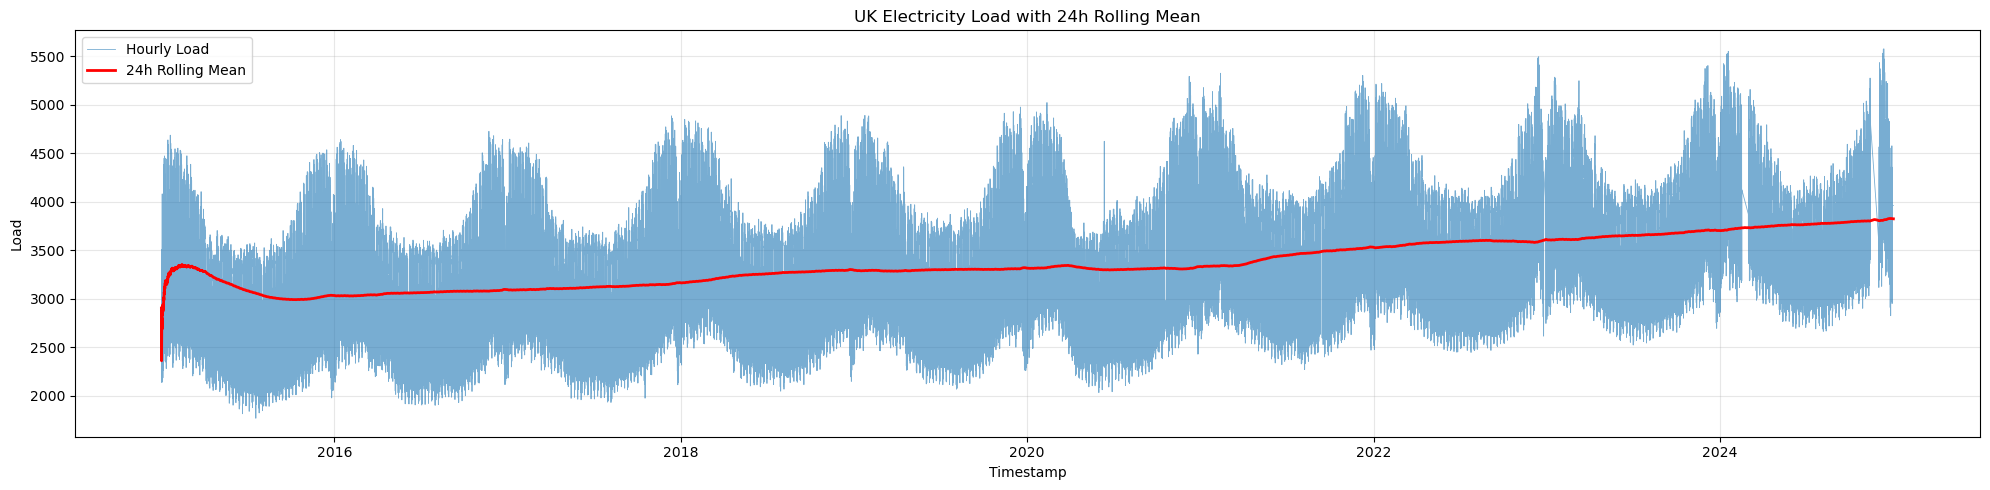

In [201]:
series_uk = df.loc[df['Country'] == 'IE', 'Load']

plt.figure(figsize=(20,5))
plt.plot(series_uk.index, series_uk.values, linewidth=0.6, alpha=0.6, label='Hourly Load')
plt.plot(series_uk.index, series_uk.rolling(window=24*30*12, min_periods=1).mean(), color='red', linewidth=2, label='24h Rolling Mean')

plt.title('UK Electricity Load with 24h Rolling Mean')
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# save figure
plt.savefig(figures_path / 'uk_load_rolling_mean.png', dpi=150)
plt.show()

In [30]:
for country in unique_countries:
    
    na = load_data[load_data['Country'] == country].isna().sum()
    if na.any() > 0:
        print(f"{country} has {na} missing values.")
    #print(len(load_data[load_data['Country'] == country]))

HR has Country    0
Load       3
dtype: int64 missing values.
CZ has Country     0
Load       20
dtype: int64 missing values.
DK has Country    0
Load       1
dtype: int64 missing values.
EE has Country      0
Load       202
dtype: int64 missing values.
FI has Country     0
Load       60
dtype: int64 missing values.
FR has Country     0
Load       87
dtype: int64 missing values.
GR has Country     0
Load       33
dtype: int64 missing values.
HU has Country    0
Load       3
dtype: int64 missing values.
IE has Country       0
Load       2044
dtype: int64 missing values.
IT has Country     0
Load       24
dtype: int64 missing values.
LV has Country    0
Load       1
dtype: int64 missing values.
LT has Country     0
Load       66
dtype: int64 missing values.
LU has Country    0
Load       8
dtype: int64 missing values.
PL has Country    0
Load       1
dtype: int64 missing values.
RO has Country      0
Load       246
dtype: int64 missing values.
SK has Country     0
Load       70
dtype: in

In [ ]:
series = pd.Series(country_load_data['Load'].tolist(), index=country_load_data.index)
series.name = 'Load'
type(series)